In [1]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"username","key":"key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)


In [2]:
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.51G/9.51G [04:42<00:00, 32.6MB/s]
100% 9.51G/9.51G [04:42<00:00, 36.2MB/s]


In [3]:
!unzip -qq aptos2019-blindness-detection.zip

In [4]:
import pandas as pd

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


import numpy as np
from google.colab import autoviz
df_7813180649182158074 = autoviz.get_df('df_7813180649182158074')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_7813180649182158074, *['diagnosis'], **{})
chart

import numpy as np
from google.colab import autoviz
df_7813180649182158074 = autoviz.get_df('df_7813180649182158074')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_7813180649182158074, *['diagnosis'], **{})
chart

import numpy as np
from google.colab import autoviz
df_7813180649182158074 = autoviz.get_df('df_7813180649182158074')

def categorical_histogram(df, colname, figsize=(2, 1.2), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  _, ax = plt.subplots(figsize=figsize)
  bars = df[colname].value_counts()
  plt.barh(bars.index, bars.values, color=sns.palettes.mpl_palette(mpl_palette_name))
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_7813180649182158074, *['id_code'], **{})
chart

import numpy as np
from google.colab import autoviz
df_7813180649182158074 = autoviz.get_df('df_7813180649182158074')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_7813180649182158074, *['diagnosis', 'id_code'], **{'inner': 'stick'})
chart

In [27]:
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import cv2

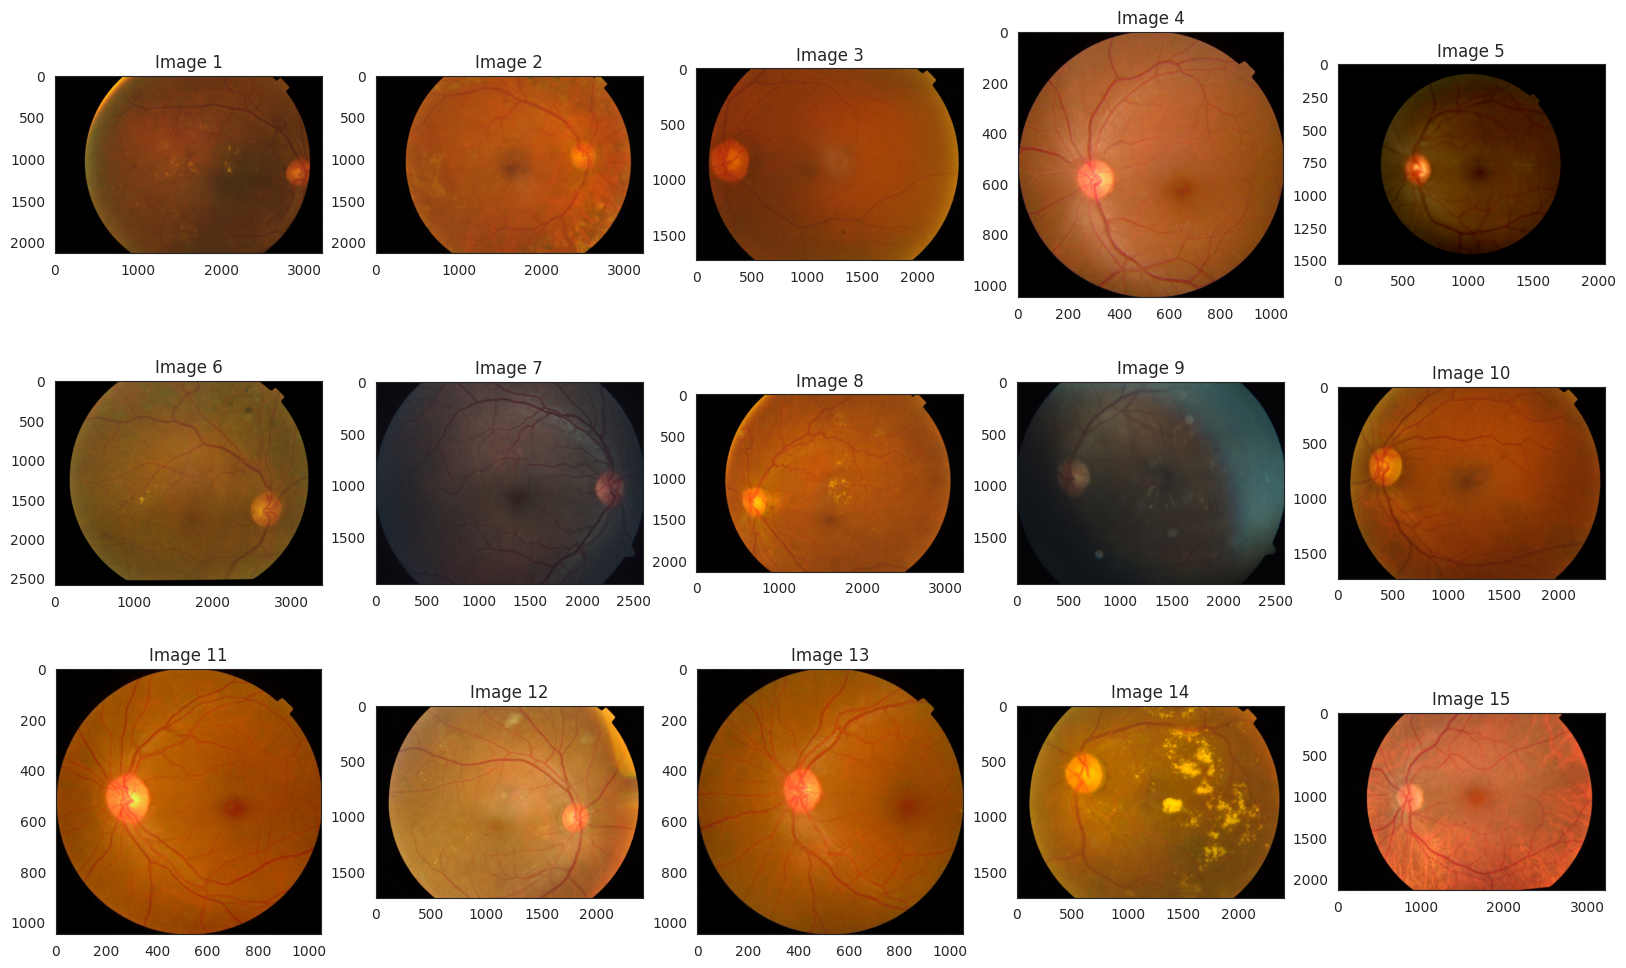

In [ ]:
sns.set_style("white")
count = 1
plt.figure(figsize=[20, 20])
for img_name in train['id_code'][:15]:
    img = cv2.imread("train_images/%s.png" % img_name)[...,[2, 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1

plt.show()

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
BATCH_SIZE = 32
HEIGHT = WIDTH =224

In [9]:
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')

In [10]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test,
        directory = "test_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
import numpy as np
import os
import datetime
%matplotlib inline

In [12]:
from tensorflow.keras.models import Model

In [13]:
resnet_base= tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

94765736/94765736 [==============================] - 3s 0us/step


In [14]:
x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)
model = Model(inputs=resnet_base.input,
              outputs=x)

In [15]:
model.compile(
  optimizer='adam',
  loss=tf.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])

In [16]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed.
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)

    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1

    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))


In [17]:
train_n = pd.read_csv('train.csv')

In [18]:
labels = train_n['diagnosis'].values.astype(int)
labels

array([2, 4, 1, ..., 2, 0, 2])

In [19]:
class_weights = generate_class_weights(labels)

In [20]:
class_weights

{0: 0.4057617728531856,
 1: 1.9794594594594594,
 2: 0.7331331331331331,
 3: 3.7948186528497407,
 4: 2.4827118644067796}

In [21]:
def get_early_stopping():

    return tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


def get_checkpoint_best_only():

    checkpoint_best_path= 'checkpoints_best_only'
    checkpoint_best= ModelCheckpoint(filepath=checkpoint_best_path,
                           frequency='epoch',
                           save_weights_only=False,
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)
    return checkpoint_best


checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#callbacks = [checkpoint_best_only, early_stopping, tensorboard_callback]
callbacks = [checkpoint_best_only, tensorboard_callback, early_stopping]

In [22]:
history = model.fit(train_generator, validation_data=valid_generator, batch_size=BATCH_SIZE, epochs=50,
                    class_weight=class_weights, callbacks=callbacks)

Epoch 1/50
92/92 [==============================] - ETA: 0s - loss: 1.4074 - accuracy: 0.5553
Epoch 1: val_accuracy improved from -inf to 0.46038, saving model to checkpoints_best_only


92/92 [==============================] - 506s 5s/step - loss: 1.4074 - accuracy: 0.5553 - val_loss: 540.3077 - val_accuracy: 0.4604
Epoch 2/50
92/92 [==============================] - ETA: 0s - loss: 1.1613 - accuracy: 0.6348
Epoch 2: val_accuracy did not improve from 0.46038
92/92 [==============================] - 474s 5s/step - loss: 1.1613 - accuracy: 0.6348 - val_loss: 2.3022 - val_accuracy: 0.1052
Epoch 3/50
92/92 [==============================] - ETA: 0s - loss: 1.1367 - accuracy: 0.6051
Epoch 3: val_accuracy did not improve from 0.46038
92/92 [==============================] - 421s 5s/step - loss: 1.1367 - accuracy: 0.6051 - val_loss: 3.5426 - val_accuracy: 0.1052
Epoch 4/50
92/92 [==============================] - ETA: 0s - loss: 1.0290 - accuracy: 0.6437
Epoch 4: val_accuracy did not improve from 0.46038
92/92 [==============================] - 422s 5s/step - loss: 1.0290 - accuracy: 0.6437 - val_loss: 1.5881 - val_accuracy: 0.4440
Epoch 5/50
92/92 [=========================

92/92 [==============================] - 454s 5s/step - loss: 0.9100 - accuracy: 0.7270 - val_loss: 1.4496 - val_accuracy: 0.4672
Epoch 9/50
92/92 [==============================] - ETA: 0s - loss: 0.8631 - accuracy: 0.7352
Epoch 9: val_accuracy did not improve from 0.46721
92/92 [==============================] - 429s 5s/step - loss: 0.8631 - accuracy: 0.7352 - val_loss: 1.3809 - val_accuracy: 0.4658
Epoch 10/50
92/92 [==============================] - ETA: 0s - loss: 0.8256 - accuracy: 0.7491
Epoch 10: val_accuracy did not improve from 0.46721
92/92 [==============================] - 424s 5s/step - loss: 0.8256 - accuracy: 0.7491 - val_loss: 1.5019 - val_accuracy: 0.2582
Epoch 11/50
92/92 [==============================] - ETA: 0s - loss: 0.8161 - accuracy: 0.7645
Epoch 11: val_accuracy improved from 0.46721 to 0.56011, saving model to checkpoints_best_only


92/92 [==============================] - 457s 5s/step - loss: 0.8161 - accuracy: 0.7645 - val_loss: 1.1809 - val_accuracy: 0.5601
Epoch 12/50
92/92 [==============================] - ETA: 0s - loss: 0.7845 - accuracy: 0.7614
Epoch 12: val_accuracy did not improve from 0.56011
92/92 [==============================] - 426s 5s/step - loss: 0.7845 - accuracy: 0.7614 - val_loss: 1.5940 - val_accuracy: 0.4372
Epoch 13/50
92/92 [==============================] - ETA: 0s - loss: 0.7635 - accuracy: 0.7775
Epoch 13: val_accuracy improved from 0.56011 to 0.67896, saving model to checkpoints_best_only


92/92 [==============================] - 449s 5s/step - loss: 0.7635 - accuracy: 0.7775 - val_loss: 0.8955 - val_accuracy: 0.6790
Epoch 14/50
92/92 [==============================] - ETA: 0s - loss: 0.7144 - accuracy: 0.7857
Epoch 14: val_accuracy did not improve from 0.67896
92/92 [==============================] - 418s 5s/step - loss: 0.7144 - accuracy: 0.7857 - val_loss: 1.3391 - val_accuracy: 0.5738
Epoch 15/50
92/92 [==============================] - ETA: 0s - loss: 0.7347 - accuracy: 0.7765
Epoch 15: val_accuracy improved from 0.67896 to 0.74727, saving model to checkpoints_best_only


92/92 [==============================] - 440s 5s/step - loss: 0.7347 - accuracy: 0.7765 - val_loss: 0.7529 - val_accuracy: 0.7473
Epoch 16/50
92/92 [==============================] - ETA: 0s - loss: 0.6982 - accuracy: 0.7829
Epoch 16: val_accuracy did not improve from 0.74727
92/92 [==============================] - 416s 5s/step - loss: 0.6982 - accuracy: 0.7829 - val_loss: 1.1583 - val_accuracy: 0.6257
Epoch 17/50
92/92 [==============================] - ETA: 0s - loss: 0.7667 - accuracy: 0.7676
Epoch 17: val_accuracy did not improve from 0.74727
92/92 [==============================] - 418s 5s/step - loss: 0.7667 - accuracy: 0.7676 - val_loss: 0.8038 - val_accuracy: 0.7240
Epoch 18/50
92/92 [==============================] - ETA: 0s - loss: 0.6543 - accuracy: 0.7993
Epoch 18: val_accuracy did not improve from 0.74727
92/92 [==============================] - 421s 5s/step - loss: 0.6543 - accuracy: 0.7993 - val_loss: 0.7941 - val_accuracy: 0.7336
Epoch 19/50
92/92 [====================

In [23]:
model.load_weights("checkpoints_best_only")

In [24]:
model.save("diabet.h5")

In [26]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(
        dataframe=train,
        directory = "train_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 3662 validated image filenames.


<ipython-input-26-65ab26ca9759>:12: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)


In [28]:
from sklearn.metrics import classification_report, confusion_matrix

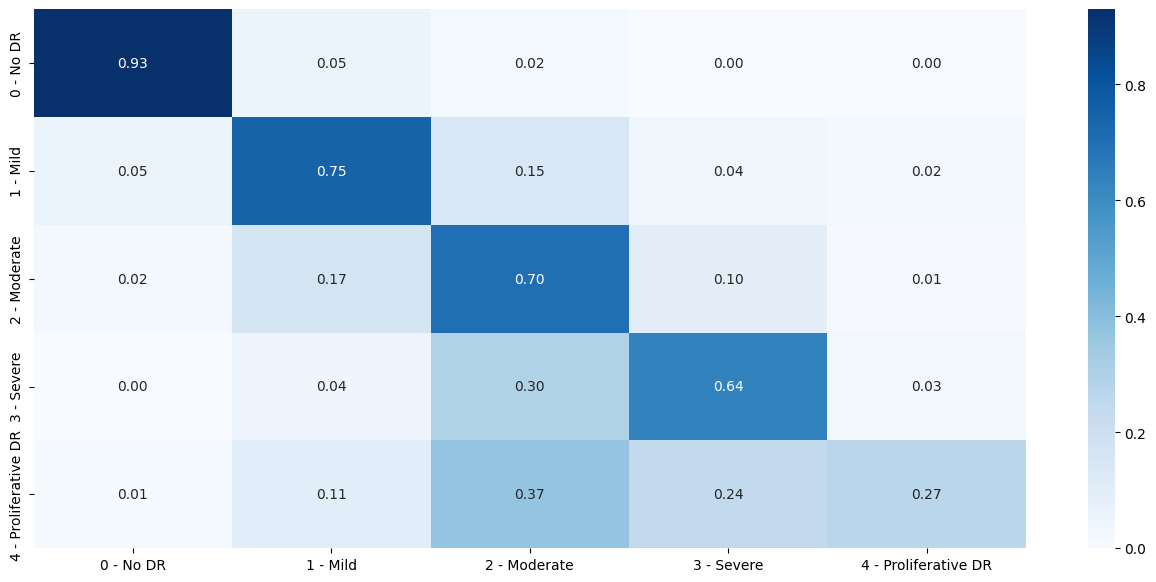

In [29]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train['diagnosis'].astype('int'), train_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [30]:
from sklearn.metrics import cohen_kappa_score

In [31]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train['diagnosis'].astype('int'), weights='quadratic'))

Train Cohen Kappa score: 0.841


In [32]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]

<ipython-input-32-f15d0776b5d0>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)


In [33]:
filenames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv('submission.csv',index=False)
results.head(10)

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,3
2,006efc72b638,3
3,00836aaacf06,2
4,009245722fa4,2
5,009c019a7309,2
6,010d915e229a,2
7,0111b949947e,0
8,01499815e469,3
9,0167076e7089,1


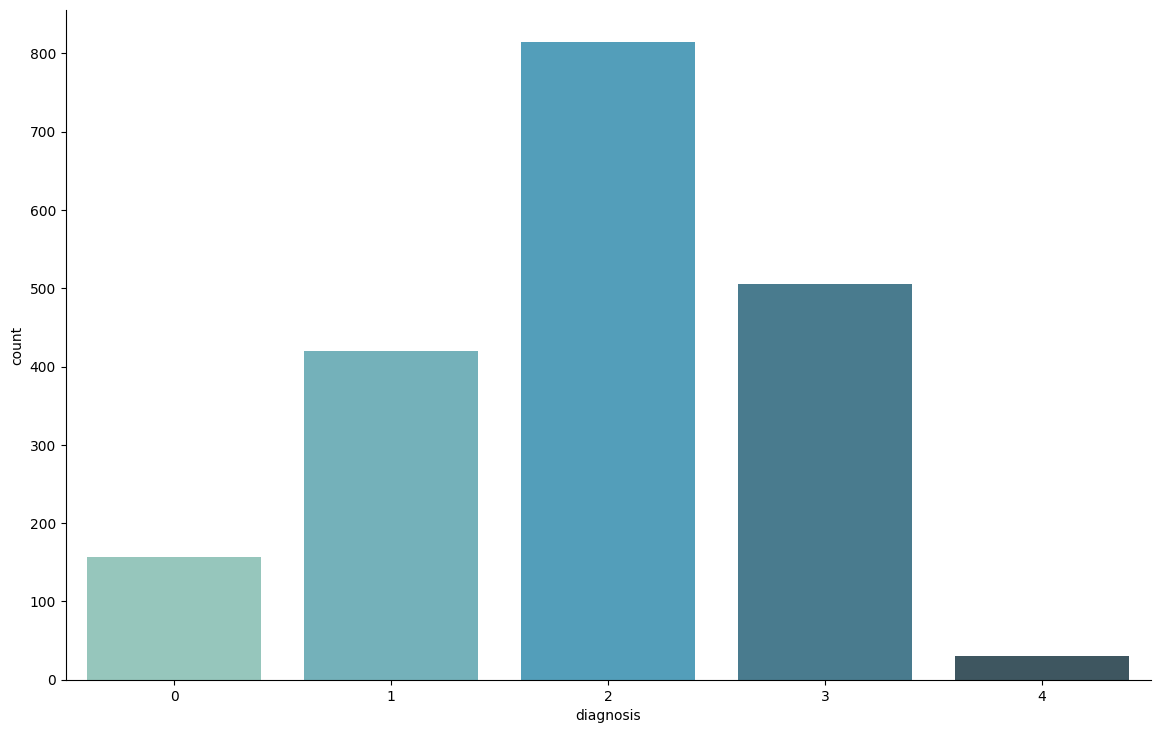

In [34]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=results, palette="GnBu_d")
sns.despine()
plt.show()